Dataset: <br>
Paper: [Influence of P300 latency jitter on event related potential-based brain–computer interface performance](https://iopscience.iop.org/article/10.1088/1741-2560/11/3/035008/pdf)

# Import

In [ ]:
!apt install octave >> /dev/null
!pip install oct2py >> /dev/null



Extracting templates from packages: 100%


In [ ]:
from google.colab import drive

import scipy.io
import os
import math
from scipy import stats
from oct2py import Oct2Py
from oct2py import octave

from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statistics import mean

from tqdm import tqdm

In [ ]:
# for training the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import CCA

In [ ]:
import tensorflow_probability as tfp
dist = tfp.distributions

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# please create a shortcut of EEG Speller folder in the home page of drive before running this cell
%cd '/content/drive/MyDrive/EEG Speller'

/content/drive/.shortcut-targets-by-id/1Eod78EztGxtaKeNvgBhj15rYJrdlDjG_/EEG Speller


# Constants

In [ ]:
recording_freq = 256
timepoint_to_ms = 1 / recording_freq * 1000
epoch_length = 800
ms_to_timepoint = 1 / timepoint_to_ms
channels = ['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4',
        'FCz', 'C3', 'C4', 'CP3', 'CPz', 'CP4']
meta = {
  'recording_freq':recording_freq, # unit: Hz
  'inter_stimulus_duration':32, # unit: timepoint
  'stimulus_duration':32, # unit: timepoint
  'stimulation_num':8,
  'timepoint_to_ms':timepoint_to_ms, # equals 3.90625 ms/timepoint
  'ms_to_timepoint':ms_to_timepoint, # equals 0.256 timepoint/ms
  'run_num':3,
  'trial_num':6,
  'target_num':2,
  'inter_trial_interval': 512, # unit: timepoint 
  'non_target_num':10,
  'stimuli_num': 36, # 6 by 6 grdi speller
  'channel_num':len(channels),
  'epoch_length': epoch_length, # unit: ms
  'epoch_length_timepoint':int(epoch_length * ms_to_timepoint), # unit: timepoint
  'labels':{"idle": 0, "non-target": 1, "target": 2},
  'trials':[1544, 9736, 17928, 26120, 34312, 42504],
  'channels':channels, # the exact same order as X
  'subjects_num':10,
  'total_targets':12,
  'soa': 64 # unit: timepoint
}

soa = meta['soa'] * meta['timepoint_to_ms'] / 1000 # convert to seconds
iti = meta['inter_trial_interval'] * meta['timepoint_to_ms'] / 1000 
isi = meta['inter_stimulus_duration'] * meta['timepoint_to_ms'] / 1000 

## Set seed

In [ ]:
RANDOM_SEED = 2021
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED) 

# Description of the dataset P300
* 3 runs per session, 6 trials (i.e. character) per run, 8 simulations per trial, 12 classes (10 targets + 2 non targets). 
* 16 channels, 10-10 montage
* y (0:idle, 1:non-target, 2:target)
* y_stim (0: idle, 1: class1, 2: class2, ... 12: class12)
* 256 Hz, 3.90625 ms/timepoint

## Helper Functions

In [ ]:
def get_dict_from_data(patient_data):
  # Params:
  #   patient_data: the unprocessed individual patient data (i.e. already indexed)
  # Return:
  #   dictionary consisting of:
  #   X: (run, timepoints, channels)
  #   y: (run, timepoints * stimulations * (target))
  #   y_stim (run, timepoints, 13)
  #   channels: 1d-array
  #   trial: 1d-array
  #   fs: int

  data = patient_data['data']
  # removing redundent dimension
  data = data[0][:]
  filtered_data = [] # (run, None), second dimension is not fixed
  for i, run in enumerate(data):
    filtered_data.append(run[0][0])

  X_stack = [] 
  y_stack = []  
  y_stim_stack = []
  for i, run in enumerate(filtered_data):
    channels = np.concatenate(run[0][0])
    X = run[1]
    y = np.squeeze(run[2])
    y_stim = np.squeeze(run[3])
    trial = np.squeeze(run[4]) - 1 # the trial is shifted by one for some reason
    fs = np.squeeze(run[5])
    X_stack.append(X)
    y_stack.append(y)
    y_stim_stack.append(y_stim)
  X_stack = np.stack(X_stack, axis=0) 
  y_stack = np.stack(y_stack, axis=0)
  y_stim_stack = np.stack(y_stim_stack, axis=0)
  return dict(channels=channels, X=X_stack, y=y_stack, y_stim=y_stim_stack, trial=trial, fs=fs)

In [ ]:
def get_epoch_data(patient_dict, meta):
  # Params:
  #   patient_dict: dictionary of the patient data
  #   meta: meta data of the recording
  #
  # Return:
  #   epoched_potential: (run_num, trial_num, stimulation_num, (target_num + non_target_num), epoch_length_timepoint, channel_num)
  #   epoched_label: (run_num, trial_num, stimulation_num, (target_num + non_target_num))

  epoch_length_timepoint = meta['epoch_length_timepoint']
  channel_num = meta['channel_num']
  run_num = meta['run_num']
  trial_num = len(meta['trials'])
  stimulation_num = meta['stimulation_num']
  target_num = meta['target_num']
  non_target_num = meta['non_target_num']
  trials = meta['trials']
  labels = meta['labels']
  stimulus_duration = meta['stimulus_duration']
  inter_stimulus_duration = meta['inter_stimulus_duration']

  epoched_potential = np.zeros([run_num, trial_num, stimulation_num, target_num + non_target_num, epoch_length_timepoint, channel_num])
  epoched_label = np.zeros([run_num, trial_num, stimulation_num, target_num + non_target_num])
  epoched_label_stim = np.zeros([run_num, trial_num, stimulation_num, target_num + non_target_num])

  count = 0
  for i in range(run_num):
    for j, trial in enumerate(trials):
      counter = trial
      for k in range(stimulation_num):
        for l in range(target_num + non_target_num):
          label = patient_dict['y'][i][counter]
          label_stim = patient_dict['y_stim'][i][counter]
          data = patient_dict['X'][i][counter: counter + epoch_length_timepoint, :]
          epoched_potential[i, j, k, l, :, :] = data
          if label == labels["target"]:
            epoched_label[i, j, k, l] = meta['labels']['target']
            count += 1
          elif label == labels["non-target"]:
            epoched_label[i, j, k, l] = meta['labels']['non-target']
            count += 1
          epoched_label_stim[i, j, k, l] = label_stim
          counter += stimulus_duration + inter_stimulus_duration
  assert (count == run_num * trial_num * stimulation_num * (target_num + non_target_num)), "epoch label mismatch! please inspect the epoch labels"
  
  # re-aligned stimulations such that all stimulations can be ordered the same
  mask = epoched_label_stim - 1 # make zero-based
  for i in range(run_num):
    for j in range(trial_num):
      rows = np.repeat(np.arange(len(epoched_label[i, j]))[:, None], epoched_label[i, j].shape[1], axis=1)
      columns = mask[i, j].astype(np.int).argsort()
      epoched_label[i, j] = epoched_label[i, j][rows, columns]
      epoched_potential[i, j] = epoched_potential[i, j, rows, columns, :, :]

  # reshape to desired
  return epoched_potential, epoched_label, epoched_label_stim

In [ ]:
def separate_rows_columns(epoched_data, epoched_label):
  '''
  Args:
   epoched_data: (run_num, trial_num, stimulation_num, (target_num + non_target_num), epoch_length_timepoint, channel_num)
   epoched_label: (run_num, trial_num, stimulation_num, (target_num + non_target_num))

  Return:
    epoched_data_separated: (run_num, trial_num, stimulation_num, 2, total_targets / 2, epoch_length_timepoint, channel_num)
    epoched_label_separated: (run_num, trial_num, stimulation_num, 2, total_targets / 2)
  
  '''

  channel_num = meta['channel_num']
  run_num = meta['run_num']
  trial_num = len(meta['trials'])
  stimulation_num = meta['stimulation_num']
  total_targets = meta['total_targets']
  epoch_length_timepoint = meta['epoch_length_timepoint']

  num_rows_cols = int(total_targets / 2)

  epoched_data_separated = np.empty([run_num, trial_num, stimulation_num, 2, num_rows_cols, epoch_length_timepoint, channel_num])
  epoched_label_separated = np.empty([run_num, trial_num, stimulation_num, 2, num_rows_cols])

  # Separating the data/labels into (2, total_targets) -> first 6 are row values, last 6 are col values
  for i in range(run_num):
    for j in range(trial_num):
      for k in range(stimulation_num):
        # Separating the labels
        cur_labels = np.expand_dims(epoched_label[i, j, k], axis = 1)
        split_label = np.vsplit(cur_labels, 2)
        epoched_label_separated[i, j, k, 0] = split_label[0].squeeze()
        epoched_label_separated[i, j, k, 1] = split_label[1].squeeze()

        # Separating the data (please double check this part, the y has been verified)
        cur_data = epoched_data[i, j, k]
        split_data = np.vsplit(cur_data, 2)
        epoched_data_separated[i, j, k, 0] = split_data[0]
        epoched_data_separated[i, j, k, 1] = split_data[1]
        
  return epoched_data_separated, epoched_label_separated


In [ ]:
def generate_class_weights(y, n_classes):
  '''
  Args: 
    y (int array): (n_samples,) from 0, ..., n_classes
  '''
  weights = len(y) / (n_classes * np.bincount(y))
  class_weights = {}
  for i in range(n_classes):
    class_weights[i] = weights[i]
  return class_weights

In [ ]:
def calculateITR(accuracy, soa, num_stimulation_row, num_stimulation_col, inter_trial_interval, num_stimuli):
  '''
  Args:
    accuracy            (int)
    soa                 (int)
    num_stimulation_row (int)
    num_stimulation_col (int)
    inter_trial_interal (int)
    num_stimuli         (int)
  '''
  accuracy = 0.99999 if 1 else accuracy # Avoid taking log of 0
  B = math.log(num_stimuli, 2) + accuracy * math.log(accuracy, 2) + ((1-accuracy) * math.log((1-accuracy)/(num_stimuli - 1), 2))
  T = ((soa * ((num_stimulation_row * 6) + (num_stimulation_col * 6))) + inter_trial_interval) / 60
  return B, T, B/T

## Load all patient data

In [ ]:
data_path = "data/Covert and overt ERP-based BCI (009-2014)/P300 Speller"
patient_data = [scipy.io.loadmat(os.path.join(data_path, file)) for file in os.listdir(data_path)]

## Take a look at AO1S

In [ ]:
patient_1 = get_dict_from_data(patient_data[0])

Epoch the data

In [ ]:
X, y, epoched_label_stim = get_epoch_data(patient_1, meta)
X_all_stims = X.reshape([-1, X.shape[-2], X.shape[-1]])
y_all_stims = y.reshape([-1])
target_avg_potential = X_all_stims[y_all_stims == meta['labels']['target'], :, :].mean(axis=0)
non_target_avg_potential = X_all_stims[y_all_stims == meta['labels']['non-target'], :, :].mean(axis=0)

Averaged P300 potential waveforms at the Cz electrode position obtained from a representative subject using the P300
interfaces. <br>
Note: overlapping epochs

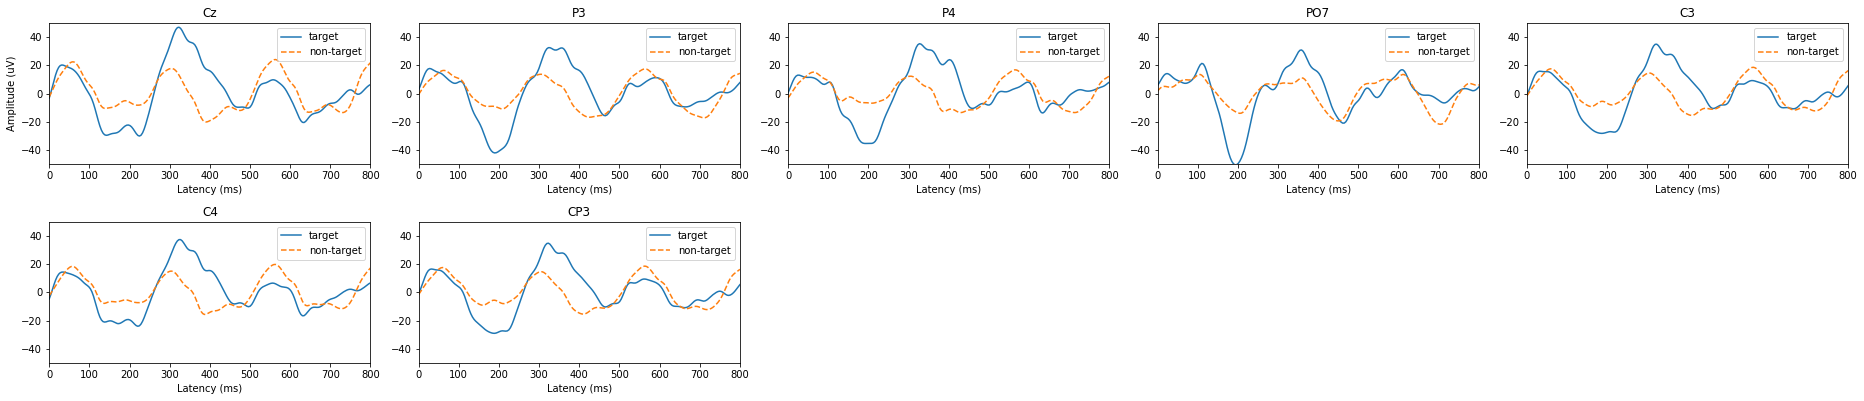

In [ ]:
ncols = 5
nrows = 3
xmin, xmax = 0, epoch_length
ymin, ymax = -50, 50
plt.figure(figsize=(26, 8))
channels_to_try = ['Cz', 'P3', 'P4', 'PO7', 'C3', 'C4', 'CP3']

for i, channel in enumerate(channels_to_try):
  plt.subplot(nrows, ncols, i + 1)
  channel_idx = meta['channels'].index(channel)
  xticks = np.linspace(0, meta['epoch_length'], meta['epoch_length_timepoint'])
  ax = sns.lineplot(x=xticks, y=target_avg_potential[:, channel_idx], label='target')
  ax.set_title(channel)
  ax.set_xlim(xmin, xmax)
  ax.set_ylim(ymin, ymax)
  if i % len(channels_to_try) == 0:
    ax.set_ylabel('Amplitude (uV)')
  ax.set_xlabel('Latency (ms)')
  sns.lineplot(x=xticks, y=non_target_avg_potential[:, channel_idx], label='non-target', linestyle='--')
  ax.legend(loc='upper right')
plt.tight_layout()

## Modeling

### Helper Functions

In [ ]:
def getDynamicITROfPatients(d_stim_prob_all_patients, dynamic_acc_all_patients):
  dynamic_itr_patients = np.empty([meta['subjects_num']])
  for subject in tqdm(range(meta['subjects_num'])):
    dynamic_probs = d_stim_prob_all_patients[subject]

    cur_result = 0
    avg_itr = 0
    for run in range(meta['run_num']):
      # Get the average  of the row, col stim we stopped at for this run
      avg_row_stopped_stim = 0
      avg_col_stopped_stim = 0
      for trial in range(meta['trial_num']): 
        avg_row_stopped_stim += dynamic_probs[run][trial][4]
        avg_col_stopped_stim += dynamic_probs[run][trial][5]
      
      avg_row_stopped_stim /= meta['trial_num']
      avg_col_stopped_stim /= meta['trial_num']

      # Calculate itr using average of the row, col stim
      B, T, itr = calculateITR(dynamic_acc_all_patients[subject], soa, avg_row_stopped_stim, avg_col_stopped_stim, iti, meta['stimuli_num'])
      avg_itr += itr

    avg_itr /= meta['run_num']
    dynamic_itr_patients[subject] = avg_itr

  return dynamic_itr_patients

In [ ]:
# Time to predict a character over all trials and runs
def getDynamicTimeOfPatients(d_stim_prob_all_patients, dynamic_acc_all_patients):
  dynamic_time_all_patients = np.zeros(meta['subjects_num'])
  for subject in tqdm(range(meta['subjects_num'])):
    for run in range(meta['run_num']):
      avg_time_per_trial = 0
      for trial in range(meta['trial_num']):
        dynamic_row_stopped_stim = d_stim_prob_all_patients[subject][0][trial][4]
        dynamic_col_stopped_stim = d_stim_prob_all_patients[subject][0][trial][5]
        B, T, itr =  calculateITR(dynamic_acc_all_patients[subject], soa, dynamic_row_stopped_stim, dynamic_col_stopped_stim, iti, meta['stimuli_num'])
        avg_time_per_trial += T

      avg_time_per_trial /= meta['trial_num']

      # Sum up average time per trial per run
      dynamic_time_all_patients[subject] += avg_time_per_trial

    # Get average (over trial and runs) time to predict a single character 
    dynamic_time_all_patients[subject] /= meta['run_num']

  return dynamic_time_all_patients

### EEGNet

In [ ]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))
    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

#### Preprocessing
X has to be the shape (epochs, channels, timepoints, 1) <br>
y has to be the shape (epochs, class_num)

In [ ]:
class EEGNetData():
  def __init__(self, X, y):
    '''
    Args:
      X: (run_num, trial_num, stimulation_num, (target_num + non_target_num), epoch_length_timepoint, channel_num)
      y: (run_num, trial_num, stimulation_num, (target_num + non_target_num))
    Return:
      self.X: (run_num * trial_num * (target_num + non_target_num), channel_num, epoch_length_timepoint, 1)
      self.y: (run_num * trial_num * (target_num + non_target_num), 2)
    '''
    # average the stimlulations 
    X = X.mean(axis=2)
    # reshape to required dimension
    X = X.reshape([-1, X.shape[-2], X.shape[-1]])
    X = X.transpose([0, 2, 1])
    X = X[:, :, :, None]
    # since all y labels have been align stimulation-wise
    y = y[:, :, 0, :] 
    y = y.reshape([-1])
    # read just the labels of y to (0, 1, 0, 1, ... , num_classes), 0: non-target, 1: target (originally was 1: non-target and 2: target)
    y = np.where(y == 1, 0, 1)
    y = to_categorical(y, num_classes=2) # binary classification
    self.X = X
    self.y = y

In [ ]:
def get_eegnet_acc_static_stim(model, X_test_orig, y_test_orig, monte_carlo=None):
    '''
    Args:
      model: EEGNet model
      X_test_orig (array): (run_num, trial_num, stimulation_num, (target_num + non_target_num), epoch_length_timepoint, channel_num)
      y_test_orig (array): (run_num, trial_num, stimulation_num, (target_num + non_target_num))

    Return:
      stim_accs (array): (stimulation_num)  
    '''
    stim_accs = np.empty([meta['stimulation_num']])
    num_trials = meta['trial_num']
    
    # Square matrix
    num_rows = int(meta['total_targets'] / 2)
    num_cols = num_rows
    num_total = num_rows + num_cols

    for cur_stim in range(1, meta['stimulation_num'] + 1):
      row_probs = np.zeros([num_rows, num_trials])
      col_probs = np.zeros([num_cols, num_trials])

      for cur_row in range(num_rows):
        # First few rows represent the rows
        cur_row_data = EEGNetData(X_test_orig[:, :, np.arange(0, cur_stim), cur_row:cur_row+1, :, :], y_test_orig)
        predict_runs = 1
        if monte_carlo is not None:
          predict_runs = monte_carlo
        for run in range(predict_runs):
          row_probs[cur_row] += model.predict(cur_row_data.X)[:, 1]
        row_probs[cur_row] /= predict_runs

      for cur_col in range(num_cols):
        # Last few rows represent the columns
        col_idx = num_rows + cur_col
        cur_col_data = EEGNetData(X_test_orig[:, :, np.arange(0, cur_stim), col_idx:col_idx+1, :, :], y_test_orig)
        predict_runs = 1
        if monte_carlo is not None:
          predict_runs = monte_carlo
        for run in range(predict_runs):
          col_probs[cur_col] += model.predict(cur_col_data.X)[:, 1]
        col_probs[cur_col] /= predict_runs

      # Finding max index in each column 
      max_row_prob_trials = np.argmax(row_probs, axis = 0)
      max_col_prob_trials = np.argmax(col_probs, axis = 0)
      
      correct_trials_acc = 0
      for cur_trial in range(num_trials):
        # Picking one of the stimulations -> labels are the same for every stim
        row_label_idx = np.argmax(y_test_orig[0][cur_trial][0][0:num_rows])
        col_label_idx = np.argmax(y_test_orig[0][cur_trial][0][num_rows:num_total])

        if row_label_idx == max_row_prob_trials[cur_trial] and col_label_idx == max_col_prob_trials[cur_trial]:
          correct_trials_acc += 1
      
      correct_trials_acc /= num_trials
      stim_accs[cur_stim - 1] = correct_trials_acc

    return stim_accs

In [ ]:
def get_eegnet_prob_dynamic_stimulation(model, threshold, X_test_orig, y_test_orig, method, min_stim=3, monte_carlo=None):
  '''
  Args:
    threshold: Confidence threshold value for the dynamic stimulation ranging from 0-1
    X_test_orig (array): (run_num, trial_num, stimulation_num, (target_num + non_target_num), epoch_length_timepoint, channel_num)
    y_test_orig (array): (run_num, trial_num, stimulation_num, (target_num + non_target_num))
    method (int): 1 if taking the difference to compare with threshold, 0 if taking the argmax to compare with threshold

  Return:
    d_stim_prob (array): (trial_num, 6), 6 -> (row_num, col_num, row_prob, col_prob, row_stopped_stim, col_stopped_stim)
    acc (int): Accuracy using dynamic stopping -> always x/num_trials
  '''
  
  num_stimulations = meta['stimulation_num']
  num_trials = meta['trial_num']

  # Square matrix
  num_rows = int(meta['total_targets'] / 2)
  num_cols = num_rows
  num_total = num_rows + num_cols

  d_stim_prob = np.zeros([num_trials, 6])
  correct_trial_acc = 0

  for cur_trial in range(num_trials):
    # Note col and row orders are randomized every trial -> numbers represent relative to the order in they were flashed
    row_num_trial = -1
    col_num_trial = -1
    row_stopped_stim_trial = -1
    row_prob_trial = -1
    col_stopped_stim_trial = -1
    col_prob_trial = -1

    # Finding the min stimulation required to pass threshold confidence for the rows
    for cur_stim in range(1, num_stimulations + 1):
      # Probability of each row having P300 evoked for each trial and stimulation
      row_probs_stim = np.zeros([num_rows])
      # Checking prob of P300 evoked for each row (EEGNet is based on if P300 is evoked or not)
      for cur_row in range(num_rows):
        test_data_row = EEGNetData(X_test_orig[:, cur_trial:cur_trial+1, np.arange(0, cur_stim), cur_row:cur_row+1, :, :], y_test_orig)  
        predict_runs = 1
        if monte_carlo is not None:
          predict_runs = monte_carlo
        for run in range(predict_runs):
          row_probs_stim[cur_row] += model.predict(test_data_row.X)[0][1]
        row_probs_stim[cur_row] /= predict_runs

      # Sort in descending order
      sorted_idx = np.argsort(-1 * row_probs_stim)
      most_prob_idx = sorted_idx[0]
      most_prob_row = row_probs_stim[most_prob_idx]
      # Use the difference of top 2 most probable rows
      if method == 1:
        second_prob_idx = sorted_idx[1]
        second_most_prob_row = row_probs_stim[second_prob_idx]
        if cur_stim >= min_stim and (abs(most_prob_row - second_most_prob_row) >= threshold or cur_stim == num_stimulations):
          row_num_trial = most_prob_idx
          row_stopped_stim_trial = cur_stim
          row_prob_trial = most_prob_row
          break
      elif method == 2:
        if cur_stim >= min_stim and (most_prob_row >= threshold or cur_stim == num_stimulations):
          row_num_trial = most_prob_idx
          row_stopped_stim_trial = cur_stim
          row_prob_trial = most_prob_row
          break

    # Finding the min stimulation required to pass threshold confidence for the cols
    for cur_stim in range(1, meta['stimulation_num'] + 1):
      # Probability of each col having P300 evoked for each trial and stimulation
      col_probs_stim = np.zeros([num_cols])
      for cur_col in range(num_cols):
        col_idx = num_rows + cur_col
        test_data_col = EEGNetData(X_test_orig[:, cur_trial:cur_trial+1, np.arange(0, cur_stim), col_idx:col_idx+1, :, :], y_test_orig)
        predict_runs = 1
        if monte_carlo is not None:
          predict_runs = monte_carlo
        for run in range(predict_runs):
          col_probs_stim[cur_col] += model.predict(test_data_col.X)[0][1]
        col_probs_stim[cur_col] /= predict_runs

      # Sort in descending order
      sorted_idx = np.argsort(-1 * col_probs_stim)
      most_prob_idx = sorted_idx[0]
      most_prob_col = col_probs_stim[most_prob_idx]
      if method == 1:
        second_prob_idx = sorted_idx[1]
        second_most_prob_col = col_probs_stim[second_prob_idx]
        if cur_stim >= min_stim and (abs(most_prob_col - second_most_prob_col) >= threshold or cur_stim == num_stimulations):
          col_num_trial = most_prob_idx
          col_stopped_stim_trial = cur_stim
          col_prob_trial = most_prob_col
          break
      elif method == 2:
        if cur_stim >= min_stim and (most_prob_col >= threshold or cur_stim == num_stimulations):
          col_num_trial = most_prob_idx
          col_stopped_stim_trial = cur_stim
          col_prob_trial = most_prob_col
          break

    # Once the stimulation stopping points have been found for both rows and cols
    d_stim_prob[cur_trial] = np.array([row_num_trial, col_num_trial, row_prob_trial, col_prob_trial, row_stopped_stim_trial, col_stopped_stim_trial])

    # Checking if correct col/row have been predicted
    # Picking one of the stimulations -> labels are the same for every stim
    row_label_idx = np.argmax(y_test_orig[0][cur_trial][0][0:num_rows])
    col_label_idx = np.argmax(y_test_orig[0][cur_trial][0][num_rows:num_total])

    if row_label_idx == row_num_trial and col_label_idx == col_num_trial:
      correct_trial_acc += 1

  correct_trial_acc /= num_trials
  return d_stim_prob, correct_trial_acc

In [ ]:
# Return a dictionary
def get_model_acc(epochs, subject, meta, threshold=None, method=1, bayes=0, monte_carlo=1, verbose=0):
  '''
  Args:
    epochs (int): 
    subject (int): idx of the subject
    threshold: Confidence threshold value for the dynamic stimulation ranging from 0-1 
    method (int): Method to compute the dynamic threshold 
    bayes (int):  1 if using Bayesian, 0 otherwise
    monte_carlo (int): monte carlo number for Bayesian model
  Return:
    test_acc (array): (run_num, epochs) trained with all stimulations
    train_acc (array): (run_num, epochs) trained with all stimulations
    stim_acc (array): (num_stim, run_num) obtained by doing cross validation
    d_stim_prob (array): (num_run, trial_num, 6), 6 -> (row_num, col_num, row_prob, col_prob, row_stopped_stim, col_stopped_stim)
    d_stim_acc (array): (num_run)
  '''
  train_acc = np.zeros([meta['run_num'], epochs])
  test_acc = np.zeros([meta['run_num'], epochs])
  stim_acc = np.zeros([meta['stimulation_num'], meta['run_num']])
  d_stim_prob = np.zeros([meta['run_num'], meta['trial_num'], 6])
  d_stim_acc = np.zeros([meta['run_num']])

  kf = KFold(n_splits=meta['run_num'])
  patient = get_dict_from_data(patient_data[subject])
  # split data into train, test, and validation sets
  X, y, epoched_label_stim = get_epoch_data(patient, meta)
  # use one of the three runs as test set
  for i, (train_index, test_index) in enumerate(kf.split(X)):
    if verbose >= 1:
      run_num = meta['run_num']
      print(f'Fold {i + 1} / {run_num}')
    X_train_orig, y_train_orig = X[train_index], y[train_index]
    X_test_orig, y_test_orig = X[test_index], y[test_index]
    
    train_data = EEGNetData(X_train_orig, y_train_orig)
    X_train, y_train = train_data.X, train_data.y
    test_data = EEGNetData(X_test_orig, y_test_orig)
    X_test, y_test = test_data.X, test_data.y

    model = None
    history = None

    if bayes == 1:
      # build the Bayesian model
      model = BayesNet(nb_classes = 2, num_training = len(y_train), Chans = len(channels), 
                      Samples = meta['epoch_length_timepoint'], 
                      dropoutRate = 0.5)
      model.compile(loss='categorical_crossentropy', optimizer='adam', 
                    metrics = ['acc'])
      # train the model
      class_weights = generate_class_weights(y_train.argmax(axis=1), 2)
      history = model.fit(X_train, y_train, batch_size = 16, epochs = epochs, 
                            verbose = 0, validation_data=(X_test, y_test), 
                            class_weight = class_weights)
    else:
      # build the EEGNet model
      model = EEGNet(nb_classes = 2, Chans = len(channels), 
                    Samples = meta['epoch_length_timepoint'], 
                    dropoutRate = 0.5)
      model.compile(loss='categorical_crossentropy', optimizer='adam', 
                    metrics = ['acc'])
      
      # train the model
      class_weights = generate_class_weights(y_train.argmax(axis=1), 2)
      history = model.fit(X_train, y_train, batch_size = 16, epochs = epochs, 
                              verbose = 0, validation_data=(X_test, y_test), 
                              class_weight = class_weights)
    
    train_acc[i] = history.history['acc'] 
    test_acc[i] = history.history['val_acc']
    
    # Calculating dynamic stimulation accuracy
    if threshold:
      if bayes == 1:
        d_stim_prob[test_index], d_stim_acc[test_index] = get_eegnet_prob_dynamic_stimulation(model, threshold, X_test_orig, y_test_orig, method, monte_carlo)
      else:
        d_stim_prob[test_index], d_stim_acc[test_index] = get_eegnet_prob_dynamic_stimulation(model, threshold, X_test_orig, y_test_orig, method)
    
    # Calculating static stimulation accuracy
    if threshold is None:
      if bayes == 1:
        stim_acc[:, i] = get_eegnet_acc_static_stim(model, X_test_orig, y_test_orig, monte_carlo)
      else:
        stim_acc[:, i] = get_eegnet_acc_static_stim(model, X_test_orig, y_test_orig)

  res = dict() 
  res["train_acc"]   = train_acc
  res["test_acc"]    = test_acc
  res["stim_acc"]    = stim_acc
  res["d_stim_prob"] = d_stim_prob
  res["d_stim_acc"]  = d_stim_acc
  return res

#### Dynamic Stopping | Threshold vs Mean Accuracy of Patients

In [ ]:
def get_stim_threshold_graph_accs(method, thresholds, epochs, monte_carlo=None):
  stim_threshold_graph_accs = np.zeros([len(thresholds)])
  # Sum the mean patient accuracy at each threshold
  for idx, threshold in tqdm(enumerate(thresholds)):
    for subject in range(meta['subjects_num']): 
      res = None
      if monte_carlo:
        # Running Bayesian model
        res = get_model_acc(epochs, subject, meta, threshold, method, 1, monte_carlo)
      else:
        # Running EEGNet model
        res = get_model_acc(epochs, subject, meta, threshold, method)

      # d_stim_acc.shape  (array): (num_run)
      stim_threshold_graph_accs[idx] += mean(res['d_stim_acc']) 

  # Get average accuracy for all patients at each threshold
  for idx in range(len(stim_threshold_graph_accs)): 
    stim_threshold_graph_accs[idx] /= meta['subjects_num']
  
  return  stim_threshold_graph_accs

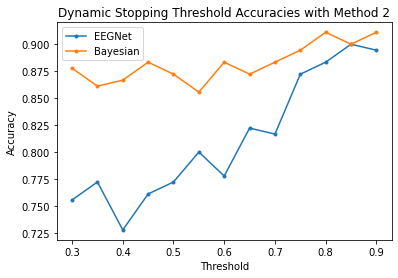

In [ ]:
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Dynamic Stopping Threshold Accuracies with Method 2")
xticks = thresholds_method_2
plt.plot(xticks, eegnet_thresholds_method_2_accs, marker = '.')
plt.plot(xticks, bayes_thresholds_method_2_accs, marker = '.')
plt.legend(['EEGNet', 'Bayesian'])

#### Accuracy based on sorted SSC patients (trained at each stimulation)

In [ ]:
epochs = 40
threshold = 0.9
static_stim_num = 4
dynamic_method = 2

static_acc_all_patients = np.empty(meta['subjects_num'])
dynamic_acc_all_patients = np.empty(meta['subjects_num'])
d_stim_prob_all_patients = []

# Collecting data for each patient (used in future calculations with ITR and Time)
for i in range(meta['subjects_num']):
  print('Patient:', i)
  # Get the static stim accuracy at static_stim_num
  static_res = get_model_acc(epochs, i, meta)
  dynamic_res = get_model_acc(epochs, i, meta, threshold, dynamic_method)
  static_acc_all_patients[i] = mean(static_res['stim_acc'][static_stim_num - 1])
  dynamic_acc_all_patients[i] = mean(dynamic_res['d_stim_acc'])
  d_stim_prob_all_patients.append(dynamic_res['d_stim_prob'])

sorted_static_acc_all_patients_idxs = np.argsort(static_acc_all_patients)
sorted_static_acc_all_patients = np.array(static_acc_all_patients)[sorted_static_acc_all_patients_idxs]
sorted_dynamic_acc_all_patients = np.array(dynamic_acc_all_patients)[sorted_static_acc_all_patients_idxs]

Patient: 0
Patient: 1
Patient: 2
Patient: 3
Patient: 4
Patient: 5
Patient: 6
Patient: 7
Patient: 8
Patient: 9


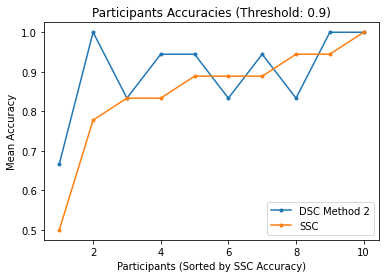

In [ ]:
xticks = np.arange(1, meta['subjects_num'] + 1)
plt.plot(xticks, sorted_dynamic_acc_all_patients, marker = '.')
plt.plot(xticks, sorted_static_acc_all_patients, marker = '.')

plt.title('Participants Accuracies (Threshold: ' + str(threshold) + ')')
plt.xlabel('Participants (Sorted by SSC Accuracy)')
plt.ylabel('Mean Accuracy');
plt.legend(['DSC Method ' + str(dynamic_method), 'SSC'])

#### ITR based on sorted patients (trained at each stimulation)
static:  patient vs. itr for those stimulations we used
dynamic: patient vs. average itr across runs using average of the row and col stim we stopped at in each run

In [ ]:
static_itr_patients = np.empty([meta['subjects_num']])

# Dynamic ITR
dynamic_itr_patients = getDynamicITROfPatients(d_stim_prob_all_patients, dynamic_acc_all_patients)

# Static ITR
for i in range(meta['subjects_num']):
  B, T, itr = calculateITR(static_acc_all_patients[i], soa, static_stim_num, static_stim_num, iti, meta['stimuli_num'])
  static_itr_patients[i] = itr 

sorted_static_itr_patients_idxs = np.argsort(static_itr_patients)
sorted_static_itr_patients = np.array(static_itr_patients)[sorted_static_itr_patients_idxs]
sorted_dynamic_itr_patients = np.array(dynamic_itr_patients)[sorted_static_itr_patients_idxs]

100%|██████████| 10/10 [00:00<00:00, 12622.04it/s]


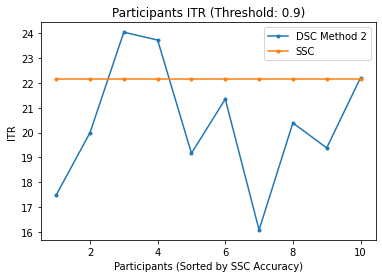

In [ ]:
#Plotting graph
xticks = np.arange(1, meta['subjects_num'] + 1)
plt.plot(xticks, sorted_dynamic_itr_patients, marker='.')
plt.plot(xticks, sorted_static_itr_patients, marker='.')
plt.title('Participants ITR (Threshold: ' + str(threshold) + ')')
plt.xlabel('Participants (Sorted by SSC Accuracy)')
plt.ylabel('ITR');
plt.legend(['DSC Method ' + str(dynamic_method), 'SSC'])

#### Time to predict character based on sorted patients (trained at each stimulation)

In [ ]:
ssc_stim = 5

static_time_all_patients = np.empty(meta['subjects_num'])
dynamic_time_all_patients = np.empty(meta['subjects_num'])

for subject in range(meta['subjects_num']):
  B, T, itr = calculateITR(static_acc_all_patients[i], soa, ssc_stim, ssc_stim, iti, meta['stimuli_num'])
  static_time_all_patients[subject] = T

dynamic_time_all_patients = getDynamicTimeOfPatients(d_stim_prob_all_patients, dynamic_acc_all_patients)

sorted_static_time_all_patients_idxs = np.argsort(static_time_all_patients)
sorted_static_time_all_patients = np.array(static_time_all_patients)[sorted_static_time_all_patients_idxs]
sorted_dynamic_time_all_patients = np.array(dynamic_time_all_patients)[sorted_static_time_all_patients_idxs]

100%|██████████| 10/10 [00:00<00:00, 5967.14it/s]


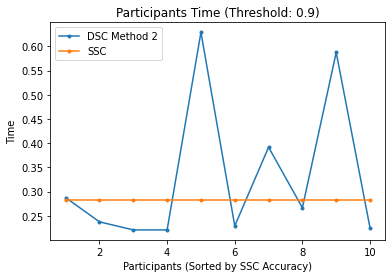

In [ ]:
#Plotting
xticks = np.arange(1, meta['subjects_num'] + 1)
plt.plot(xticks, sorted_dynamic_time_all_patients, marker='.')
plt.plot(xticks, sorted_static_time_all_patients, marker='.')
plt.title('Participants Time (Threshold: ' + str(threshold) + ')')
plt.xlabel('Participants (Sorted by SSC Accuracy)')
plt.ylabel('Time');
plt.legend(['DSC Method ' + str(dynamic_method), 'SSC'])

### BayesNet

In [ ]:
class BayesNet(tf.keras.Model):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    def __init__(self, nb_classes, num_training, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
      super(BayesNet, self).__init__()
      self.kl_divergence_function = lambda q, p, _: dist.kl_divergence(q, p) / tf.cast(num_training, dtype=tf.float32)
      self.nb_classes = nb_classes
      self.num_training = num_training
      self.Chans = Chans
      self.Samples = Samples
      self.dropoutRate = dropoutRate
      self.kernLength = kernLength
      self.F1 = F1
      self.D = D
      self.F2 = F2
      self.norm_rate = norm_rate
      # whether to return the normalized logits
      self.softmax_on = True
      # layers
      if dropoutType == 'SpatialDropout2D':
          self.dropoutType = SpatialDropout2D
      elif dropoutType == 'Dropout':
          self.dropoutType = Dropout
      else:
          raise ValueError('dropoutType must be one of SpatialDropout2D '
                          'or Dropout, passed as a string.')
      self.conv1 = Conv2D(self.F1, (1, self.kernLength), padding = 'same',
                                    input_shape = (self.Chans, self.Samples, 1),
                                    use_bias = False)
      self.b1A = BatchNormalization()
      self.dconv1 = DepthwiseConv2D((self.Chans, 1), use_bias = False, 
                                    depth_multiplier = self.D,
                                    depthwise_constraint = max_norm(1.))
      self.b1B = BatchNormalization()
      self.a1 = Activation('elu')
      self.avg1 = AveragePooling2D((1, 4))
      self.d1 = self.dropoutType(self.dropoutRate)

      self.sconv2 = SeparableConv2D(self.F2, (1, 16),
                                    use_bias = False, padding = 'same')
      self.b2 = BatchNormalization()
      self.a2 = Activation('elu')
      self.avg2 = AveragePooling2D((1, 8))
      self.d2 = self.dropoutType(self.dropoutRate)

      self.f = Flatten(name = 'flatten')
      self.classifier = tfp.layers.DenseFlipout(self.nb_classes, name = 'dense', kernel_divergence_fn=self.kl_divergence_function)
      self.a3 = Activation('softmax', name = 'softmax')
    def call(self, inputs):
      assert inputs.shape[1:] == (self.Chans, self.Samples, 1)
      ##################################################################
      block1       = self.conv1(inputs)
      block1       = self.b1A(block1)
      block1       = self.dconv1(block1)
      block1       = self.b1B(block1)
      block1       = self.a1(block1)
      block1       = self.avg1(block1)
      block1       = self.d1(block1)
      
      block2       = self.sconv2(block1)
      block2       = self.b2(block2)
      block2       = self.a2(block2)
      block2       = self.avg2(block2)
      block2       = self.d2(block2)
          
      flatten      = self.f(block2)
      dense        = self.classifier(flatten)
      softmax      = self.a3(dense)
      return softmax

#### Getting Data For Graphing

In [ ]:
def getDynamicDataForGraphing(epochs, threshold, method, monte_carlo=None):
  dynamic_acc_all_patients = np.empty(meta['subjects_num'])
  d_stim_probs_all_patients = []

  # Getting data for static and dynamic (to be used in later code blocks)
  for subject in range(meta['subjects_num']):
    print("Subject :", subject)

    res = None
    if monte_carlo:
      res = get_model_acc(epochs, subject, meta, threshold, method, 1, monte_carlo)
    else:
      res = get_model_acc(epochs, subject, meta, threshold, method)
      
    dynamic_acc_all_patients[subject] = mean(res['d_stim_acc'])
    d_stim_probs_all_patients.append(res['d_stim_prob'])

  
  return dynamic_acc_all_patients, d_stim_probs_all_patients

#### Accuracy vs stimulation num for static EEGNet and Bayesian models

Static method is used 

In [ ]:
epochs = 40
monte_carlo = 5
static_threshold = None
dynamic_threshold_one = 0.9
dynamic_threshold_two = 0.9
methodOne = 1
methodTwo = 2

# Static 
static_eegnet_res = []
static_bayes_res = []

# Getting data for static
for subject in tqdm(range(meta['subjects_num'])):
  #static_eegnet_res.append(get_model_acc(epochs, subject, meta))
  static_bayes_res.append(get_model_acc(epochs, subject, meta, static_threshold, methodOne, 1, monte_carlo))

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
100%|██████████| 10/10 [09:49<00:00, 58.92s/it]


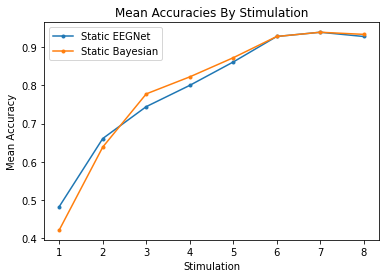

In [ ]:
# Getting averages across stimulations
eegnet_avg_stim_acc_all_patients = np.zeros([meta['stimulation_num']])
bayes_avg_stim_acc_all_patients = np.zeros([meta['stimulation_num']])

# Static Bayesian across stimulations
for subject in range(meta['subjects_num']):
  eegnet_accs = static_eegnet_res[subject]['stim_acc']
  bayes_accs = static_bayes_res[subject]['stim_acc']

  for run in range(meta['run_num']):
    for stim in range(meta['stimulation_num']):
      eegnet_avg_stim_acc_all_patients[stim] += eegnet_accs[stim][run]
      bayes_avg_stim_acc_all_patients[stim] += bayes_accs[stim][run]

for stim in range(meta['stimulation_num']):
  eegnet_avg_stim_acc_all_patients[stim] /= meta['run_num'] * meta['subjects_num']
  bayes_avg_stim_acc_all_patients[stim] /= meta['run_num'] * meta['subjects_num']

# Plotting
xticks = np.arange(1, meta['stimulation_num'] + 1)
line1 = plt.plot(xticks, eegnet_avg_stim_acc_all_patients, marker = '.')
line2 = plt.plot(xticks, bayes_avg_stim_acc_all_patients, marker = '.')

plt.title('Mean Accuracies By Stimulation')
plt.xlabel('Stimulation')
plt.ylabel('Mean Accuracy');
plt.legend(['Static EEGNet', 'Static Bayesian'])

In [ ]:
# Getting averages across patients for one stimulation (static)
bayes_static_mean = np.empty([meta['subjects_num']])
bayes_ssc_stim = 6

for subject in range(meta['subjects_num']):
  bayes_static_mean[subject] = mean(static_bayes_res[subject]['stim_acc'][bayes_ssc_stim - 1])

#### Accuracy comparing Dynamic EEGNet and Bayesian on all patients 

In [ ]:
# Getting data for each dynamic method type 
epochs = 40
monte_carlo = 5
dynamic_threshold_one = 0.9
dynamic_threshold_two = 0.9

# Method two
eegnet_dynamic_acc_all_patients_method_two, eegnet_d_stim_probs_all_patients_method_two = getDynamicDataForGraphing(epochs, dynamic_threshold_two, 2, monte_carlo=None)
bayes_dynamic_acc_all_patients_method_two, bayes_d_stim_probs_all_patients_method_two = getDynamicDataForGraphing(epochs, dynamic_threshold_two, 2, monte_carlo)

Subject : 0
Subject : 1
Subject : 2
Subject : 3
Subject : 4
Subject : 5
Subject : 6
Subject : 7
Subject : 8
Subject : 9
Subject : 0


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Subject : 1
Subject : 2
Subject : 3
Subject : 4
Subject : 5
Subject : 6
Subject : 7
Subject : 8
Subject : 9


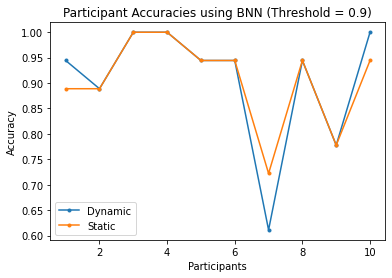

In [ ]:
xticks = np.arange(1, meta['subjects_num'] + 1)
eegnet_dynamic_mean_method_two = round(mean(eegnet_dynamic_acc_all_patients_method_two), 2)
bayes_dynamic_mean_method_two = round(mean(bayes_dynamic_acc_all_patients_method_two), 2)
static_mean = round(mean(bayes_static_mean), 2)

plt.plot(xticks, bayes_dynamic_acc_all_patients_method_two, marker = '.')
plt.plot(xticks, bayes_static_mean, marker = '.')
plt.title('Participant Accuracies using BNN (Threshold = 0.9)')
plt.xlabel('Participants')
plt.ylabel('Accuracy');
plt.legend(['Dynamic', 'Static'])

#### ITR comparing Dynamic EEGNet and Bayesian on all patients

In [ ]:
static_bayes_itr_patients = np.empty([meta['subjects_num']])

# Method two
dynamic_eegnet_itr_patients_method_two = getDynamicITROfPatients(eegnet_d_stim_probs_all_patients_method_two, eegnet_dynamic_acc_all_patients_method_two)
dynamic_bayes_itr_patients_method_two = getDynamicITROfPatients(bayes_d_stim_probs_all_patients_method_two, bayes_dynamic_acc_all_patients_method_two)

# Static Bayesian 
for subject in range(meta['subjects_num']):
  static_mean_acc = mean(static_bayes_res[subject]['stim_acc'][bayes_ssc_stim - 1])
  B, T, itr = calculateITR(static_mean_acc, soa, bayes_ssc_stim, bayes_ssc_stim, iti, meta['stimuli_num'])
  static_bayes_itr_patients[subject] = itr

100%|██████████| 10/10 [00:00<00:00, 14889.26it/s]


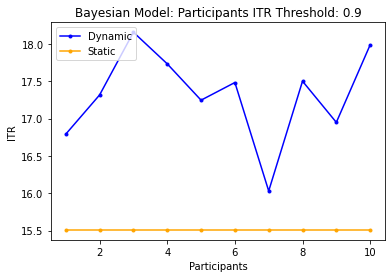

In [ ]:
static_mean_itr = round(mean(static_bayes_itr_patients), 2)
dynamic_mean_itr = round(mean(dynamic_bayes_itr_patients_method_two), 2)

#Plotting graph 
xticks = np.arange(1, meta['subjects_num'] + 1)
plt.plot(xticks, dynamic_bayes_itr_patients_method_two, marker='.', color='blue')
plt.plot(xticks, static_bayes_itr_patients, marker='.', color='orange')
plt.title('Bayesian Model: Participants ITR ' + 'Threshold: ' + str(dynamic_threshold_two))
plt.xlabel('Participants')
plt.ylabel('ITR');
plt.legend(['Dynamic', 'Static'], loc='upper left')

#### Time comparing Dynamic EEGNet and Bayesian on sorted patients

In [ ]:
static_bayes_time_patients = np.empty([meta['subjects_num']])
num_characters_to_predict = meta['trial_num']
num_runs = meta['run_num']

# Method two
dynamic_eegnet_time_patients_method_two = getDynamicTimeOfPatients(eegnet_d_stim_probs_all_patients_method_two, eegnet_dynamic_acc_all_patients_method_two)
dynamic_bayes_time_patients_method_two = getDynamicTimeOfPatients(bayes_d_stim_probs_all_patients_method_two, bayes_dynamic_acc_all_patients_method_two)

# Static Bayesian
for subject in range(meta['subjects_num']):
  static_mean_acc = mean(static_bayes_res[subject]['stim_acc'][bayes_ssc_stim - 1])
  B, T, itr = calculateITR(static_mean_acc, soa, bayes_ssc_stim, bayes_ssc_stim, iti, meta['stimuli_num'])
  static_bayes_time_patients[subject] = T

# Convert from minutes to seconds
for subject in range(meta['subjects_num']):
  dynamic_bayes_time_patients_method_two[subject] *= 60
  dynamic_eegnet_time_patients_method_two[subject] *= 60
  static_bayes_time_patients[subject] *= 60

100%|██████████| 10/10 [00:00<00:00, 8671.29it/s]


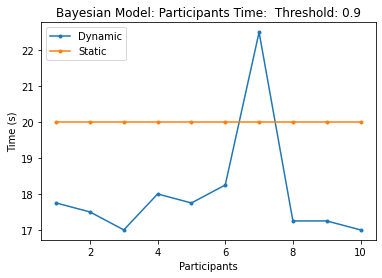

In [ ]:
static_mean_time = round(mean(static_bayes_time_patients), 2)
dynamic_mean_time = round(mean(dynamic_bayes_time_patients_method_two), 2)

#Plotting graph
xticks = np.arange(1, meta['subjects_num'] + 1)
plt.plot(xticks, dynamic_bayes_time_patients_method_two, marker='.')
plt.plot(xticks, static_bayes_time_patients, marker='.')
plt.title('Bayesian Model: Participants Time: ' + ' Threshold: ' + str(dynamic_threshold_two))
plt.xlabel('Participants')
plt.ylabel('Time (s)')
plt.legend(['Dynamic', 'Static'], loc='upper left')

#### Store graph information in dataframe

In [ ]:
bayes_times = np.concatenate((static_bayes_time_patients, dynamic_bayes_time_patients_method_two))
bayes_accs = np.concatenate((bayes_static_mean, bayes_dynamic_acc_all_patients_method_two))
bayes_itrs = np.concatenate((static_bayes_itr_patients, dynamic_bayes_itr_patients_method_two))

concatenated = np.vstack((bayes_accs, bayes_times))

dynamic_bayes_df = pd.DataFrame(bayes_times, columns = ['Time'])
dynamic_bayes_df['accs']=pd.Series(bayes_accs)
dynamic_bayes_df['itrs']=pd.Series(bayes_itrs)

# Save to csv
dynamic_bayes_df.to_csv("graph_data.csv")